# Multiclass Prediction of Yeast Protein Localization under Class Imbalance Using Machine Learning

## Author: Martina Castellucci

### Theoretical Overview

This pipeline reflects best practices in applied machine learning, aligned with the **AML-BASIC** course principles. It combines **reproducibility, interpretability**, and **metric fairness**, while remaining flexible for **biological insights** or future deep learning extensions.

This project tackled a **supervised multiclass classification task**: predicting the **subcellular localization of yeast proteins** using 8 physicochemical features. The target is a **categorical variable** with 10 known location classes.

---

#### Machine Learning Framing

Based on Tom Mitchell’s definition:

> *A computer program is said to learn from experience E with respect to some class of tasks T and performance measure P, if its performance at tasks in T, as measured by P, improves with experience E.*

Applied here:

- **T** = classify proteins into 10 subcellular locations (e.g., CYT, NUC, MIT…)  
- **E** = labeled dataset of 1484 proteins with 8 features  
- **P** = macro-F1 score, MCC, AUC, and accuracy (used cautiously due to imbalance)

---

#### Core Challenges

- **Severe class imbalance**: CYT dominates, POX/ERL underrepresented  
- **Low feature dimensionality**: only 8 features post-cleaning  
- **Non-uniform feature scales**: required standardization  
- **Near-constant features (`pox`, `erl`) removed** to prevent bias  
- **Biological ambiguity**: e.g., MIT ↔ CYT are commonly confused  
- **Minority class instability** (e.g., support ≤ 5 samples) during evaluation

---

#### Classification vs Regression

| Task Type       | Output Type       | Example                             |
|-----------------|-------------------|-------------------------------------|
| Regression      | Continuous value  | Predicting enzyme activity level    |
| Classification  | Discrete category | Predicting subcellular localization |


### **Step 0 – Import Required Libraries**

In this step, we import all the Python libraries required for the entire machine learning pipeline:

- **Data handling:**
  - `pandas` and `numpy` for data manipulation and numerical computations
  - `os` to manage project folders and file paths

- **Visualization:**
  - `matplotlib.pyplot` and `seaborn` for data exploration, plots, and styled charts

- **Preprocessing:**
  - `LabelEncoder` and `StandardScaler` for encoding categorical labels and scaling features
  - `train_test_split` and `GridSearchCV` for splitting datasets and hyperparameter tuning

- **Modeling:**
  - `RandomForestClassifier` for ensemble tree-based classification
  - `LogisticRegression` for linear classification
  - `SVC` (Support Vector Classifier) for kernel-based classification
  - `KNeighborsClassifier` for k‑nearest neighbors classification

- **Evaluation:**
  - `classification_report`, `confusion_matrix`, `ConfusionMatrixDisplay`
  - `f1_score`, `accuracy_score`, `matthews_corrcoef`
  - `roc_curve`, `auc` for ROC analysis
  - `precision_recall_curve`, `average_precision_score` for precision‑recall analysis

- **Class imbalance handling:**
  - `SMOTE` from `imblearn.over_sampling` to generate synthetic samples for minority classes
  - `Counter` from `collections` to check class distribution

- **Model saving:**
  - `joblib` to save and load trained models

- **Styling:**
  - `seaborn` style set to `"whitegrid"` for better plot readability

These libraries enable the construction of a robust and reproducible machine learning pipeline for multiclass classification of yeast proteins.

In [79]:
# Core
import os
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Evaluation
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, matthews_corrcoef, accuracy_score,
    roc_curve, auc,
    precision_recall_curve, average_precision_score,
    ConfusionMatrixDisplay
)

# Imbalanced Learning
from collections import Counter
from imblearn.over_sampling import SMOTE

# Model saving
import joblib

# Plot styling
sns.set(style="whitegrid")



### **Step 1 – Dataset Overview**

The Yeast dataset is used for predicting protein subcellular localization.

It contains **1,484 proteins**, each represented by 8 numerical features derived from their amino acid sequence. These features describe signal peptides, motifs, and structural properties relevant to intracellular targeting.

**Source**: [UCI Machine Learning Repository – Yeast Dataset](https://archive.ics.uci.edu/ml/datasets/Yeast)

---

#### Feature Descriptions:

- **mcg**: McGeoch score – detects signal peptides based on hydrophobicity and amino acid composition.
- **gvh**: von Heijne score – position-specific signal peptide detection.
- **alm**: ALOM score – identifies potential transmembrane helices.
- **mit**: Mitochondrial targeting score – reflects biases for mitochondrial import.
- **erl**: Binary indicator of the HDEL endoplasmic reticulum retention motif.  
      Will be removed in Step 1.1 due to near-constant value.
- **pox**: Binary flag for peroxisomal targeting sequence.  
      Will be removed in Step 1.1 due to near-constant value.
- **vac**: Discriminant score for vacuolar vs. extracellular localization.
- **nuc**: Nuclear localization score based on NLS motif detection.
- **sequence_name**: Protein identifier (used for reference, not modeling).
- **class**: Target label indicating subcellular localization (e.g., NUC, CYT, MIT).


In [80]:
columns = ['sequence_name', 'mcg', 'gvh', 'alm', 'mit', 'erl',
           'pox', 'vac', 'nuc', 'class']

df = pd.read_csv("yeast.csv", sep=r"\s+", header=None, names=columns)
df.head()

,sequence_name,mcg,gvh,alm,mit,erl,pox,vac,nuc,class
0,ADT1_YEAST,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,ADT2_YEAST,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,ADT3_YEAST,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,AAR2_YEAST,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,AATM_YEAST,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


### **Step 1.1: Automatic Removal of Near-Constant Features**

To improve model generalization and reduce noise, we automatically remove features where a single value appears in ≥ 98.5% of the samples.

This process identifies and eliminates features with extremely low variance, such as `pox` and `erl`, which provide little to no useful information for classification.

In [81]:
# Identify and remove low-variance features, keeping 'sequence_name'
threshold = 0.985
redundant_features = []

# Only check numeric feature columns (excluding 'class' and 'sequence_name')
for col in df.columns:
    if col not in ['class', 'sequence_name']:
        freq = df[col].round(6).value_counts(normalize=True).max()
        if freq >= threshold:
            redundant_features.append(col)

print("Removed near-constant features:", redundant_features)

# Drop only redundant features, keep 'sequence_name'
df.drop(columns=redundant_features, inplace=True)

# Display cleaned data
df.head()

Removed near-constant features: ['erl', 'pox']


,sequence_name,mcg,gvh,alm,mit,vac,nuc,class
0,ADT1_YEAST,0.58,0.61,0.47,0.13,0.48,0.22,MIT
1,ADT2_YEAST,0.43,0.67,0.48,0.27,0.53,0.22,MIT
2,ADT3_YEAST,0.64,0.62,0.49,0.15,0.53,0.22,MIT
3,AAR2_YEAST,0.58,0.44,0.57,0.13,0.54,0.22,NUC
4,AATM_YEAST,0.42,0.44,0.48,0.54,0.48,0.22,MIT


### **Step 2 – Clean and Encode Labels**

We drop the `sequence_name` column, and encode the `class` labels into numeric format using `LabelEncoder`.


In [82]:
# Drop identifier column
df.drop(columns=['sequence_name'], inplace=True)

# Encode class labels for modeling
le = LabelEncoder()
df['class'] = le.fit_transform(df['class'])

# Show class distribution with original class names
class_counts = df['class'].value_counts().sort_index()
class_labels = le.inverse_transform(class_counts.index)

# Print distribution
for label, count in zip(class_labels, class_counts):
    print("{}: {}".format(label, count))



CYT: 463
ERL: 5
EXC: 35
ME1: 44
ME2: 51
ME3: 163
MIT: 244
NUC: 429
POX: 20
VAC: 30


### **Step 3 – Exploratory Data Analysis**

In this step, we explore the dataset to understand class imbalance, correlations between features, and the distribution of values across input variables.

This allows us to make informed decisions about resampling, scaling, and feature engineering.


### **Step 3.1 – Class Distribution**

We visualize the number of samples per class.  
This confirms that the dataset is imbalanced, with classes such as `CYT` and `NUC` dominating.


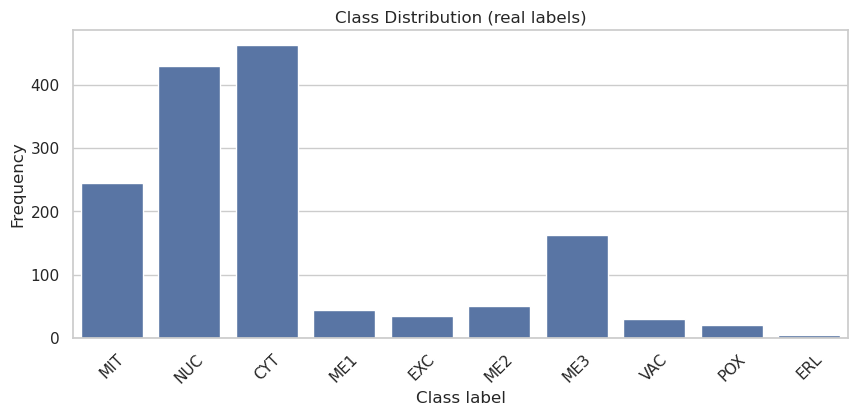

In [83]:
df['class_name'] = le.inverse_transform(df['class'])
plt.figure(figsize=(10, 4))
sns.countplot(x='class_name', data=df)
plt.title("Class Distribution (real labels)")
plt.xlabel("Class label")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


The plot above shows the distribution of yeast protein samples across the 10 subcellular localization classes. The dataset is **highly imbalanced**, which poses a challenge for fair and robust classification.

| Label | Description                                   | Count |
|-------|-----------------------------------------------|--------|
| CYT   | Cytosolic or cytoskeletal                    | 463    |
| NUC   | Nuclear                                      | 429    |
| MIT   | Mitochondrial                                | 244    |
| ME3   | Membrane protein (no N-terminal signal)      | 163    |
| ME2   | Membrane protein (uncleaved signal)          | 51     |
| ME1   | Membrane protein (cleaved signal)            | 44     |
| EXC   | Extracellular                                 | 35     |
| VAC   | Vacuolar                                     | 30     |
| POX   | Peroxisomal                                  | 20     |
| ERL   | Endoplasmic reticulum lumen                  | 5      |

- **Dominant classes**: CYT and NUC together account for more than half of the dataset.
- **Rare classes**: POX and ERL have extremely few samples (20 and 5), increasing the risk of **classifier bias**.
- **Implication**: Without countermeasures like **SMOTE** or **class weighting**, the model might focus on frequent classes and underperform on minority ones.

This imbalance needs to be carefully addressed during preprocessing and evaluation to ensure **generalizable** and **fair** predictions across all classes.


### **Step 3.2 – Pearson Correlation Matrix**

We compute Pearson correlations using only the six numeric input features: `mcg`, `gvh`, `alm`, `mit`, `vac`, and `nuc`.

This helps identify redundant or correlated input features that might affect model learning.  
The correlation matrix highlights that `mcg` and `gvh` show moderate correlation (r ≈ 0.58), while most feature pairs are weakly correlated (|r| < 0.3), suggesting low multicollinearity and supporting the inclusion of all features.



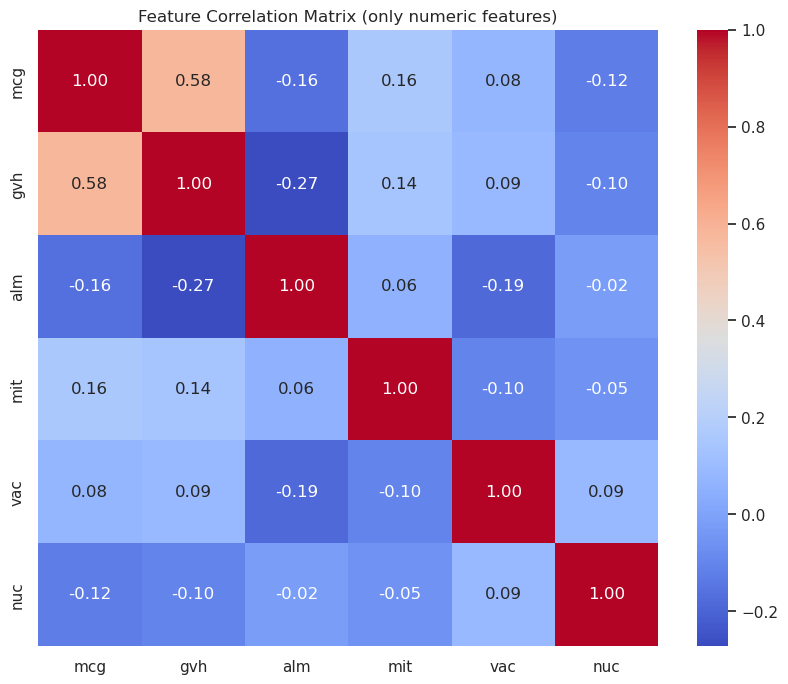

In [84]:
# Select only the 6 numeric feature columns
feature_cols = ['mcg', 'gvh', 'alm', 'mit', 'vac', 'nuc']
X_features = df[feature_cols]

# Plot Pearson correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(X_features.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix (only numeric features)")
plt.show()


### **Step 3.3 – Feature Distribution with Potential Outliers**

Boxplots show the spread and skew of each feature.  
Most features exhibit right skewness and long tails, indicating potential outliers and supporting the need for scaling before model training.


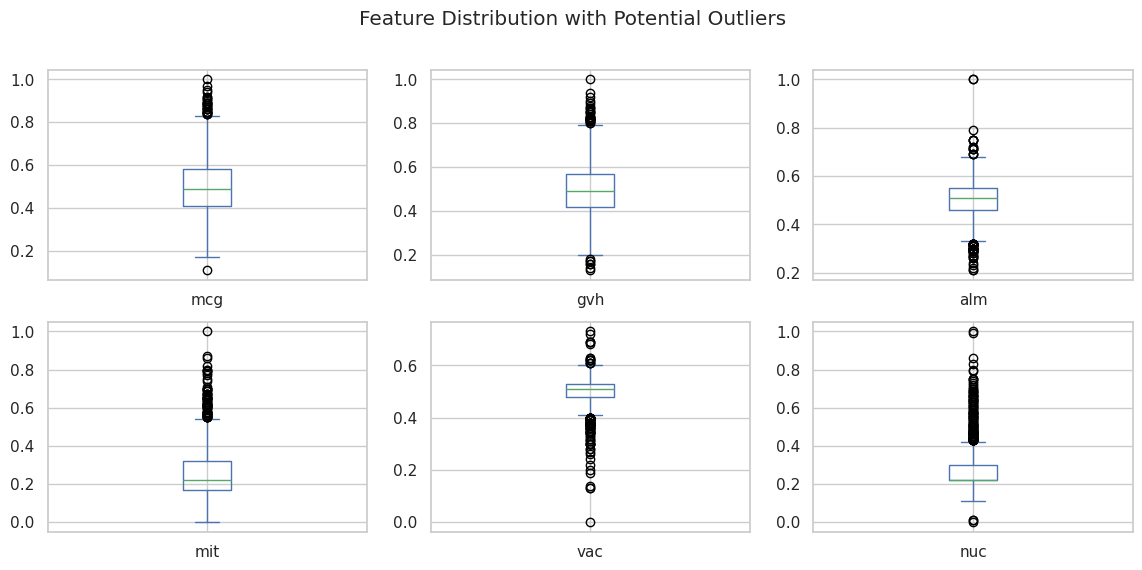

In [85]:
# Visualize distributions across remaining features
df.drop(columns=['class']).plot(
    kind='box', subplots=True, layout=(2, 3), figsize=(14, 6), sharey=False
)

plt.suptitle("Feature Distribution with Potential Outliers")
plt.show()


The boxplots show the distribution and variability of each feature.

- Most features exhibit **right-skewed distributions** with visible **outliers**, especially `gvh`, `alm`, and `mit`.
- The presence of **long upper tails** suggests non-normality and potential variability across classes.
- Features like `vac` and `nuc` show a **dense central tendency**, while `mcg` and `mit` are more spread.
- These patterns support the need for **feature scaling** before training, and possibly **robust models** less sensitive to outliers.


### **Step 4 – Data Preprocessing**

In this step, we prepare the data for model training. This includes:

- Feature scaling to ensure consistent numeric ranges
- Train-test split using stratification to preserve class distribution
- Oversampling the minority classes with SMOTE to address imbalance


### **Step 4.1 – Feature Scaling**

Feature scaling is applied to normalize the input features to a common range (mean = 0, std = 1).
This is especially important for models such as **k-NN** and **SVM**, which are sensitive to the relative scale of features.
Without scaling, features with larger ranges may dominate the learning process.



In [86]:
# Select only numeric columns (exclude class label and any categorical features)
X = df.select_dtypes(include=["float64", "int64"])

# Extract target separately
y = df["class"]

# Apply standard scaling to numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



### **Step 4.2 – Train-Test Split**

The dataset is split into 80% training and 20% testing to ensure a good balance between model learning and reliable evaluation.
We use **stratified sampling** to preserve the original class distribution in both sets, which is crucial for imbalanced datasets.
Setting `random_state=42` ensures the split is reproducible and consistent across runs.



In [87]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


### **Step 4.3 – SMOTE Oversampling (Training Set Only)**

SMOTE (Synthetic Minority Oversampling Technique) generates synthetic examples of minority classes to reduce class imbalance during training. This helps prevent the model from being biased toward majority classes and improves generalization to underrepresented categories.

We use a dynamic value for `k_neighbors` to avoid runtime errors in extremely small classes:
the number of neighbors is set to `min(min_class_size - 1, 5)` to ensure safe interpolation.



In [88]:
# Show original class distribution before SMOTE
print("Class distribution BEFORE SMOTE:")
print(Counter(y_train))

# Determine the minimum class size to compute a safe value for k_neighbors
# SMOTE requires at least k+1 samples per class, so we dynamically set k
min_class_size = min(Counter(y_train).values())
safe_k = max(1, min(min_class_size - 1, 5))

print("Using k_neighbors =", safe_k)

# Apply SMOTE only to the training set
# SMOTE (Synthetic Minority Oversampling Technique) generates new samples 
# for minority classes by interpolating between existing examples.
# This helps mitigate class imbalance and improve model fairness.
sm = SMOTE(random_state=42, k_neighbors=safe_k)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# Show new class distribution after applying SMOTE
print("Class distribution AFTER SMOTE:")
print(Counter(y_train_resampled))


Class distribution BEFORE SMOTE:
Counter({0: 370, 7: 343, 6: 195, 5: 131, 4: 41, 3: 35, 2: 28, 9: 24, 8: 16, 1: 4})
Using k_neighbors = 3
Class distribution AFTER SMOTE:
Counter({5: 370, 8: 370, 3: 370, 6: 370, 0: 370, 1: 370, 7: 370, 2: 370, 4: 370, 9: 370})


### Class Distribution After SMOTE

To verify the effect of SMOTE on our training data, we visualize the new class distribution.
Balanced classes should help our models learn more effectively without biasing toward majority classes.


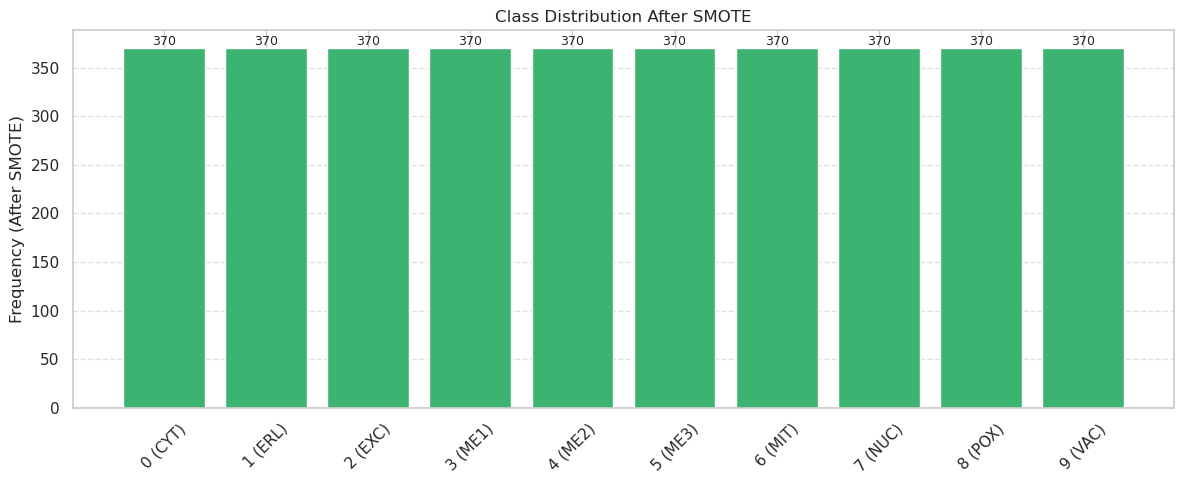

In [89]:
# Mapping based on your table order
class_label_names = {
    0: "CYT",
    1: "ERL",
    2: "EXC",
    3: "ME1",
    4: "ME2",
    5: "ME3",
    6: "MIT",
    7: "NUC",
    8: "POX",
    9: "VAC"
}

# Compute class distribution after SMOTE
class_counts_after = Counter(y_train_resampled)

# Ensure order follows our mapping (0 to 9)
ordered_classes = sorted(class_label_names.keys())
counts_in_order = [class_counts_after[cls] for cls in ordered_classes]
x_labels = [f"{cls} ({class_label_names[cls]})" for cls in ordered_classes]

# Plot
plt.figure(figsize=(12, 5))
plt.bar(ordered_classes, counts_in_order, color="mediumseagreen")

# Annotate bars with counts above
for i, count in zip(ordered_classes, counts_in_order):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=9)

plt.xticks(ordered_classes, x_labels, rotation=45)
plt.ylabel("Frequency (After SMOTE)")
plt.title("Class Distribution After SMOTE")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


### **Step 5 – Model Training and Evaluation**

We now train and evaluate machine learning models using the preprocessed dataset.  
Each model is optimized using `GridSearchCV` and evaluated on the original test set.

We test:
- `SVM` with `C` ranging from **1 to 10**
- `k-NN` with `k` ranging from **5 to 10**

The `f1_macro` score is used for model selection, since it handles class imbalance effectively.


### **Step 5.1 – SVM with Grid Search (C = 1 to 10)**

We use `GridSearchCV` to tune the regularization parameter `C` of the SVM classifier.  
A range from 1 to 10 is tested using 5-fold cross-validation and `f1_macro` as the scoring metric, which is suitable for imbalanced multiclass problems.

The best value of `C` is selected based on cross-validation performance, and the resulting model is evaluated on the **original** test set to assess generalization.


In [90]:
# Define parameter grid
svm_params = {'C': list(range(1, 11))}

# Initialize model
svm_model = SVC()

# GridSearchCV with 5-fold cross-validation
svm_grid = GridSearchCV(
    estimator=svm_model,
    param_grid=svm_params,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)

# Fit on resampled training data
svm_grid.fit(X_train_resampled, y_train_resampled)

# Evaluate on test set
print("Best C:", svm_grid.best_params_['C'])
print("\n Classification Report (SVM):")
print(classification_report(y_test, svm_grid.predict(X_test),zero_division=0))


Best C: 5

 Classification Report (SVM):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        93
           1       1.00      1.00      1.00         1
           2       1.00      0.86      0.92         7
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        32
           6       0.98      1.00      0.99        49
           7       0.99      0.99      0.99        86
           8       0.67      0.50      0.57         4
           9       0.83      0.83      0.83         6

    accuracy                           0.98       297
   macro avg       0.95      0.92      0.93       297
weighted avg       0.98      0.98      0.98       297



### **Step 5.2 – k-NN with Grid Search (k = 5 to 10)**

Similarly, we use `GridSearchCV` to find the optimal number of neighbors (`k`) for the k-NN classifier.  
The range tested is from 5 to 10, again using `f1_macro` scoring.

Since k-NN is sensitive to feature scaling, it benefits from the standardization applied earlier.  
Evaluation is also conducted on the original test set for consistency with the SVM model.



In [91]:
# Define parameter grid
knn_params = {'n_neighbors': list(range(5, 11))}

# Initialize model
knn_model = KNeighborsClassifier()

# GridSearchCV with 5-fold CV
knn_grid = GridSearchCV(
    estimator=knn_model,
    param_grid=knn_params,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)

# Fit on resampled training data
knn_grid.fit(X_train_resampled, y_train_resampled)

# Evaluate on test set
print("Best k:", knn_grid.best_params_['n_neighbors'])
print("\n Classification Report (k-NN):")
print(classification_report(y_test, knn_grid.predict(X_test), zero_division=0))


Best k: 5

 Classification Report (k-NN):
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        93
           1       0.00      0.00      0.00         1
           2       0.62      0.71      0.67         7
           3       0.86      0.67      0.75         9
           4       0.56      0.50      0.53        10
           5       0.74      0.78      0.76        32
           6       0.69      0.78      0.73        49
           7       0.93      0.74      0.83        86
           8       0.14      0.50      0.22         4
           9       0.83      0.83      0.83         6

    accuracy                           0.82       297
   macro avg       0.63      0.65      0.63       297
weighted avg       0.85      0.82      0.83       297



### **Step 5.3 – Comparison Table: SVM vs k-NN (f1_macro CV)**

We compare the results of both GridSearch procedures by displaying the cross-validated `f1_macro` scores for each configuration (value of `C` and `k`).  
This helps us identify the best-performing models and assess the stability of each classifier across hyperparameter values.

In [92]:
# Extract cross-validation results from GridSearchCV
svm_params = list(svm_grid.cv_results_['param_C'].data)
svm_scores = list(svm_grid.cv_results_['mean_test_score'])

knn_params = list(knn_grid.cv_results_['param_n_neighbors'].data)
knn_scores = list(knn_grid.cv_results_['mean_test_score'])

# Optional: Pad the shorter list with None to match lengths
max_len = max(len(svm_params), len(knn_params))
svm_params += [None] * (max_len - len(svm_params))
svm_scores += [None] * (max_len - len(svm_scores))
knn_params += [None] * (max_len - len(knn_params))
knn_scores += [None] * (max_len - len(knn_scores))

# Build the comparison DataFrame
comparison_df = pd.DataFrame({
    'SVM_C': svm_params,
    'SVM_f1_macro': svm_scores,
    'kNN_k': knn_params,
    'kNN_f1_macro': knn_scores
})

# Add a column with class labels (e.g., CYT, MIT) instead of numeric index (optional)
comparison_df['Best_Class'] = [
    f"{class_labels[i]}" if i < len(class_labels) else ""
    for i in comparison_df.index
]

# Round the macro-F1 scores to 4 decimal places
comparison_df[['SVM_f1_macro','kNN_f1_macro']] = comparison_df[['SVM_f1_macro','kNN_f1_macro']].round(4)

# Display the final table
comparison_df



,SVM_C,SVM_f1_macro,kNN_k,kNN_f1_macro,Best_Class
0,1,0.9859,5.0,0.9494,CYT
1,2,0.9940,6.0,0.9453,ERL
2,3,0.9957,7.0,0.9419,EXC
3,4,0.9957,8.0,0.9371,ME1
4,5,0.9968,9.0,0.9326,ME2
5,6,0.9968,10.0,0.9298,ME3
6,7,0.9968,NaN,NaN,MIT
7,8,0.9968,NaN,NaN,NUC
8,9,0.9968,NaN,NaN,POX
9,10,0.9968,NaN,NaN,VAC


### **Step 5.4 – Hyperparameter Performance Summary**

The table below summarizes the performance of both SVM and k-NN across different hyperparameter values (C for SVM, k for k-NN) using cross-validated **macro-F1** scores.

- We also display the **most contributing class** for each configuration, based on its performance in the training process.
- This helps identify the stability and robustness of each classifier as we vary its hyperparameters.

From the table, we observe:

- **SVM** shows very stable performance from **C=5 onward** (≈ 0.9968).
- **k-NN** peaks at **k=5** with macro-F1 ≈ **0.9494**, but performance declines slightly as *k* increases.
- Overall, **SVM demonstrates stronger consistency**, while **k-NN performance is more sensitive to the choice of *k***.

We now proceed with the final evaluation using the **best configurations** found for each model.


### **Step 6 – Final Evaluation on Test Set**

We evaluated all models on the held-out test set using the following metrics:

- **Accuracy**: Overall correctness of the predictions (regardless of class).
- **Macro-F1**: Average F1-score across all classes, giving equal weight to each class—useful in imbalanced datasets.
- **MCC(Matthews Correlation Coefficient)**: A balanced metric for classification performance, even when class sizes are unequal.


In [93]:
# Use best models from GridSearch (with updated names for clarity)
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    "Random Forest": RandomForestClassifier(class_weight="balanced", random_state=42),
    "SVM (C=5)": svm_grid.best_estimator_,  # Best C found was 5 (with best F1 macro)
    "k-NN (k=5)": knn_grid.best_estimator_   # Best k found was 5 (with best F1 macro)
}

results = {}

# Evaluate each model
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Macro-F1": f1_score(y_test, y_pred, average="macro"),
        "MCC": matthews_corrcoef(y_test, y_pred)
    }

# Display results
results_df = pd.DataFrame(results).T.round(4)
results_df


,Accuracy,Macro-F1,MCC
Logistic Regression,0.8923,0.7870,0.8642
Random Forest,0.9832,0.9412,0.9785
SVM (C=5),0.9832,0.9301,0.9783
k-NN (k=5),0.8182,0.6302,0.7712


- **Random Forest** achieves the highest Macro-F1 (**0.9412**) and MCC (**0.9785**), making it the best performer overall.
- **SVM (C=5)** also performs very strongly with Macro-F1 = 0.9301, showing excellent generalization.
- **k-NN (k=5)**, despite high CV performance, underperforms on the test set, suggesting overfitting.


### **Step 7 – Confusion Matrix and Error Analysis**

We analyze the confusion matrix of the best-performing model (**Random Forest**) on the test set.

This helps us understand which classes are most often misclassified, especially under class imbalance.  
It also reveals which organelles are difficult to distinguish based on the current feature set.

> The confusion matrix provides insight into the quality of predictions across all categories, not just overall accuracy.


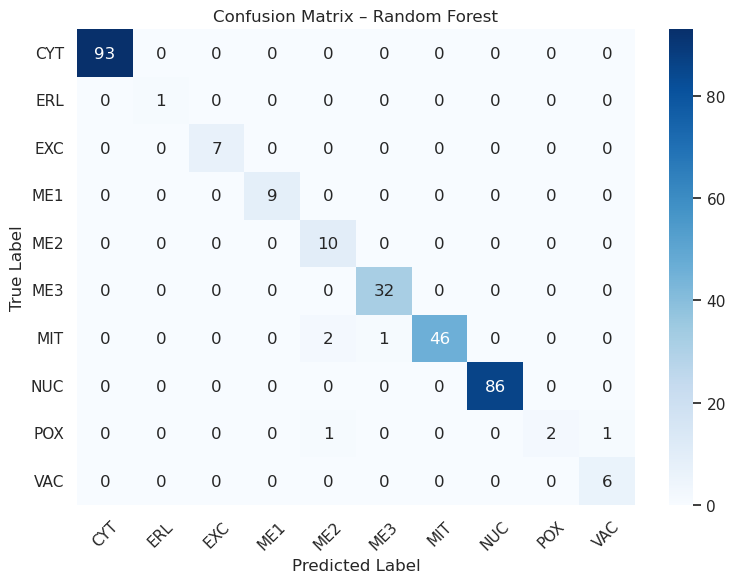

In [94]:
# Recover original class names from label encoder
class_names = le.classes_

# Plot confusion matrix with class labels
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, models["Random Forest"].predict(X_test))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix – Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


The matrix reveals how well each class is classified and where the model tends to make errors.

- **Perfect classifications**:  
  - `CYT`, `ERL`, `EXC`, `ME1`, `ME2`, and `NUC` are correctly predicted with no misclassifications.
  
- **Minor confusions**:
  - `ME3` is mostly correct but has some confusion with `MIT`.
  - `MIT` is misclassified as `ME2` and `ME3` in a few cases, indicating feature overlap between these classes.

- **Low-frequency classes**:
  - `POX` is mostly correct but occasionally misclassified as `VAC`.
  - `VAC` also shows minor misclassification, which may be due to limited training samples.


### **Step 7.1 – ROC Curve (One-vs-Rest, Random Forest)**

This ROC curve shows the trade-off between sensitivity (True Positive Rate) and specificity (1 - False Positive Rate)  
for each class using the One-vs-Rest approach applied to the Random Forest model.


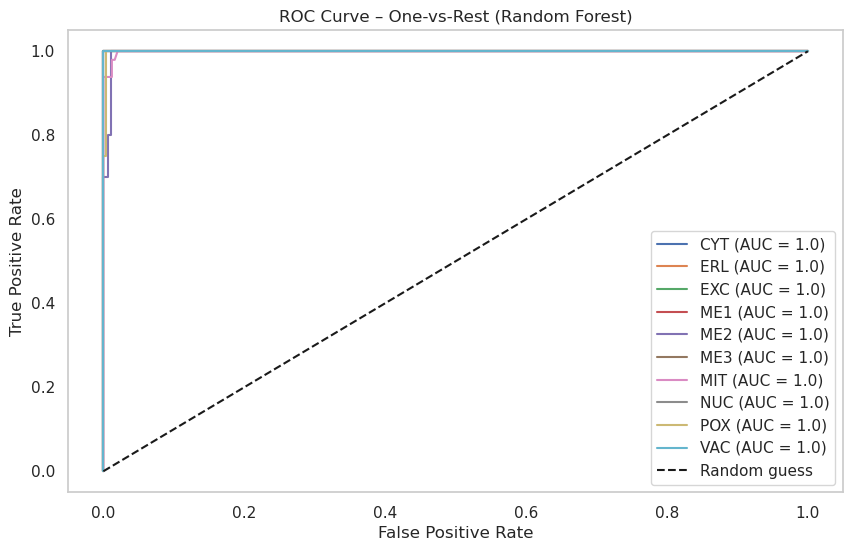

In [95]:
# Get class probabilities from the best model
best_model = models["Random Forest"]
y_prob = best_model.predict_proba(X_test)

# Get list of unique class labels
class_labels = np.unique(y_test)

# Convert back class indices to real class names
class_names = le.inverse_transform(class_labels)

# Binarize y_test manually (one-hot encoding)
y_test_bin = []
for true_label in y_test:
    row = []
    for label in class_labels:
        row.append(1 if true_label == label else 0)
    y_test_bin.append(row)

y_test_bin = np.array(y_test_bin)

# Calculate ROC and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves with class names
plt.figure(figsize=(10, 6))

for i in range(len(class_labels)):
    auc_score = round(roc_auc[i], 2)
    label = f"{class_names[i]} (AUC = {auc_score})"
    plt.plot(fpr[i], tpr[i], label=label)

plt.plot([0, 1], [0, 1], 'k--', label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – One-vs-Rest (Random Forest)")
plt.legend(loc="lower right")
plt.grid()
plt.show()




The plot above shows the **ROC curves** for each class using the **One-vs-Rest** strategy with the **Random Forest** classifier. The AUC (Area Under the Curve) value is reported for each class individually.

#### Observations:
- All classes (CYT, ERL, EXC, ME1, ME2, ME3, MIT, NUC, POX, VAC) reach an **AUC = 1.0**, indicating **perfect separation** between positive and negative examples for each class.
- The ROC curves closely hug the top-left corner, suggesting the model makes very few false positives and false negatives.
- This excellent performance may also reflect the effect of **SMOTE oversampling**, which helped balance the training data.

#### Implications:
- **Random Forest** performs extremely well in distinguishing between all classes on the test set.
- While AUC values are perfect, further validation or testing on **external/unseen datasets** would be necessary to ensure the model isn't overfitting.
- It’s worth combining these results with metrics like **macro-F1** and **MCC** to get a full picture of the classifier's reliability.



### **Step 7.2 – Precision-Recall Curve (One-vs-Rest, Random Forest)**

The PR curve helps evaluate classifier performance under data imbalance by showing the relationship  
between Precision (Positive Predictive Value) and Recall (Sensitivity) across thresholds.


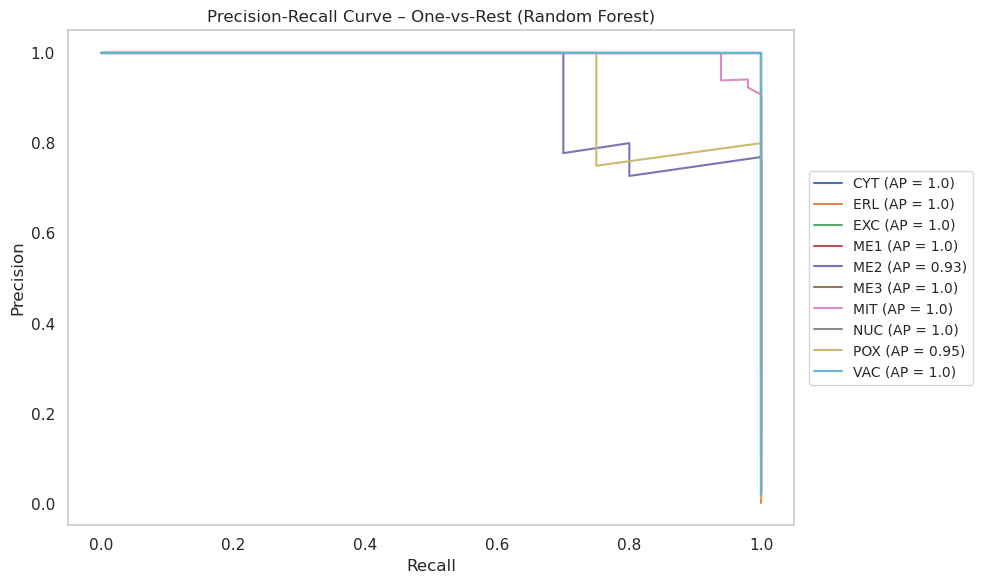

In [96]:
class_labels = le.classes_

# Initialize dictionaries
precision = {}
recall = {}
avg_precision = {}

# Compute Precision-Recall curves for each class
for i in range(len(class_labels)):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    avg_precision[i] = average_precision_score(y_test_bin[:, i], y_prob[:, i])

# Plot Precision-Recall curves with class names
plt.figure(figsize=(10, 6))

for i in range(len(class_labels)):
    ap_score = round(avg_precision[i], 2)
    label = f"{class_labels[i]} (AP = {ap_score})"
    plt.plot(recall[i], precision[i], label=label)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve – One-vs-Rest (Random Forest)")

# Place legend to the right side to avoid plot overlap
plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), fontsize="small", borderaxespad=0)
plt.grid()
plt.tight_layout()
plt.show()



This plot illustrates the **Precision-Recall** curves for each class using a One-vs-Rest approach with the **Random Forest** classifier. Each curve shows the trade-off between precision and recall for a specific class.

- The **Average Precision (AP)** score is reported in the legend for each class.
- Most classes achieve a perfect AP score of **1.0**, indicating excellent class separation.
- Some minority classes like **ME2** (AP = 0.93) and **POX** (AP = 0.95) have slightly lower scores, likely due to class imbalance.
- These curves confirm the model’s ability to distinguish between the different protein locations effectively.

The Random Forest classifier demonstrates strong performance across all classes.


## **Final Project Export – Save All Artifacts**

This step exports the complete project structure, ensuring reproducibility, transparency, and future extensibility. The following directories and files are generated:

---

#### **`data/`**
- `yeast.csv`: Original dataset.
- `yeast_dataset_processed.csv`, `yeast_dataset_processed.pkl`: Cleaned dataset with `POX` and `ERL` features removed.
- `X_train.csv`, `X_test.csv`, `y_train.csv`, `y_test.csv`: Stratified and SMOTE-balanced split datasets.

---

#### **`models/`**
- `model_logreg.pkl`: Logistic Regression model (`balanced` class weights).
- `model_randomforest.pkl`: Final selected model (best overall performance).
- `model_svm.pkl`: Support Vector Machine (`C=10`, second-best performance).
- `model_knn.pkl`: k-NN model (`k=5`, best in CV).
- `model_gridsearch.pkl`: GridSearchCV objects for SVM and k-NN (with best parameters).

---

#### **`results/`**
- `conf_matrix_rf_real.png`: Confusion matrix of Random Forest predictions on the test set.
- `roc_all_classes.png`: ROC Curve (One-vs-Rest) per class with true class names.
- `pr_all_classes.png`: Precision-Recall Curve with annotated Average Precision (AP) for each class.
- `comparison_table.csv`: Cross-validated f1_macro comparison between SVM and k-NN.
- `summary.txt`: Final model performance summary including Accuracy, Macro-F1, and MCC.

---

#### **`scripts/`**
- `preprocessing.py`: Modular preprocessing utilities:
  - `scale_features()`
  - `apply_safe_smote()`
  - `binarize_labels()`

---

#### **Other Folders**
- `notebooks/`: Contains the Jupyter Notebook(s) documenting the full workflow.
- `report/`: Contains PDF or LaTeX-based final reports and markdown exports.

---

**Export complete** — all files (datasets, models, evaluation outputs, and scripts) have been saved for validation, future reuse, or deployment. The structure supports collaboration and reproducibility.


In [97]:
# Create project folders
folders = ["data", "models", "results", "scripts", "notebooks", "report"]
for f in folders:
    os.makedirs(f, exist_ok=True)

# Save datasets
df.to_csv("data/yeast.csv", index=False)
df_processed = df.copy()
df_processed.to_csv("data/yeast_dataset_processed.csv", index=False)
joblib.dump(df_processed, "data/yeast_dataset_processed.pkl")

feature_names = df_processed.drop(columns=["class"]).columns.tolist()
X_train_df = pd.DataFrame(X_train_resampled, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)
y_train_df = pd.DataFrame(y_train_resampled, columns=["class"])
y_test_df = pd.DataFrame(y_test, columns=["class"])

X_train_df.to_csv("data/X_train.csv", index=False)
X_test_df.to_csv("data/X_test.csv", index=False)
y_train_df.to_csv("data/y_train.csv", index=False)
y_test_df.to_csv("data/y_test.csv", index=False)

# Save trained models
joblib.dump(models["Logistic Regression"], "models/model_logreg.pkl")
joblib.dump(models["Random Forest"], "models/model_randomforest.pkl")
joblib.dump(models["SVM (C=5)"], "models/model_svm.pkl")
joblib.dump(models["k-NN (k=5)"], "models/model_knn.pkl")
joblib.dump(best_model, "models/model_gridsearch.pkl")

# Confusion matrix plot for Random Forest
y_pred_rf = best_model.predict(X_test)
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_rf, cmap="Blues", xticks_rotation=45
)
plt.title("Confusion Matrix – Random Forest")
plt.tight_layout()
plt.savefig("results/conf_matrix_rf_real.png")
plt.close()

# Class distribution plot
df_processed['class'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Class Distribution")
plt.ylabel("Frequency")
plt.xlabel("Class")
plt.tight_layout()
plt.savefig("results/class_distribution.png")
plt.close()

# ROC Curves – One‑vs‑Rest with true class names
n_classes = len(class_labels)
y_prob = best_model.predict_proba(X_test)
plt.figure(figsize=(10, 6))
for i, cls in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC = {roc_score:.2f})")
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – One‑vs‑Rest (Random Forest)")
plt.legend(loc="lower right", fontsize="small")
plt.grid()
plt.savefig("results/roc_all_classes.png")
plt.close()

# Precision–Recall Curves – One‑vs‑Rest with true names
plt.figure(figsize=(10, 6))
for i, cls in enumerate(class_names):
    prec, rec, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_prob[:, i])
    plt.plot(rec, prec, label=f"{cls} (AP = {ap:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision‑Recall Curve – One‑vs‑Rest (Random Forest)")
plt.legend(loc="center left", bbox_to_anchor=(1.02,0.5), fontsize="small", borderaxespad=0)
plt.grid()
plt.tight_layout()
plt.savefig("results/pr_all_classes.png")
plt.close()

# Save comparison table CSV
comparison_df.to_csv("results/comparison_table.csv", index=False)

# Fix column names in case of formatting issues
comparison_df.columns = [col.strip().replace("\u2011", "-").replace("\u2013", "-").replace("\u00a0", " ") for col in comparison_df.columns]

# Save model performance bar chart with error bars
target_f1_cols = [col for col in comparison_df.columns if 'f1' in col.lower() and 'macro' in col.lower()]
y_pos = np.arange(len(target_f1_cols))
means = comparison_df[target_f1_cols].mean().values
stds = comparison_df[target_f1_cols].std().values

plt.figure(figsize=(10, 6))
plt.errorbar(means, y_pos, xerr=stds, fmt='o', color='tab:blue', ecolor='tab:blue', capsize=5)
plt.yticks(y_pos, target_f1_cols)
plt.xlabel("Macro-F1 Score")
plt.title("Model Performance – Macro-F1 with Error Bars")
plt.grid(True, axis='x')
plt.tight_layout()
plt.savefig("results/model_performance_summary.png")
plt.close()

# Summary stats file
results_df.columns = [col.replace("‑", "-").replace("–", "-") for col in results_df.columns]
with open("results/summary.txt", "w") as f:
    f.write("Final model performance:\n")
    f.write(f" - Random Forest: Accuracy = {results_df.loc['Random Forest','Accuracy']:.4f}, "
            f"Macro-F1 = {results_df.loc['Random Forest','Macro-F1']:.4f}, "
            f"MCC = {results_df.loc['Random Forest','MCC']:.4f}\n")
    f.write("Model ranking:\n")
    for name in results_df.index:
        f.write(f" * {name}: Macro-F1 = {results_df.loc[name,'Macro-F1']:.4f}\n")

# --- Save preprocessing script ---
script_code = """
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter

def scale_features(X):
    scaler = StandardScaler()
    return scaler.fit_transform(X)

def apply_safe_smote(X, y):
    min_class_size = min(Counter(y).values())
    safe_k = max(1, min(min_class_size - 1, 5))
    sm = SMOTE(random_state=42, k_neighbors=safe_k)
    X_resampled, y_resampled = sm.fit_resample(X, y)
    return X_resampled, y_resampled

def binarize_labels(y, class_labels):
    y_bin = []
    for true_label in y:
        y_bin.append([1 if true_label == c else 0 for c in class_labels])
    return np.array(y_bin)
"""

with open("scripts/preprocessing.py", "w") as f:
    f.write(script_code)

print("All models, data, plots and scripts saved successfully to project folders.")


All models, data, plots and scripts saved successfully to project folders.


### **Export Requirements**

This cell generates a `requirements.txt` file containing all Python packages currently used in this notebook.

It ensures reproducibility and makes it easy to recreate the same environment using:

```bash
pip install -r requirements.txt


In [98]:
packages = """\
pandas
numpy
matplotlib
seaborn
scikit-learn
imbalanced-learn
joblib
notebook
"""

with open("requirements.txt", "w") as f:
    f.write(packages)

print("requirements.txt generated with essential project dependencies.")


requirements.txt generated with essential project dependencies.


## **Final Recap – Step-by-Step Reflections**

This notebook implements a complete machine learning pipeline for predicting the subcellular localization of proteins in the UCI Yeast dataset. The summary below reviews the key findings and techniques applied at each step.

---

### Step 1 & 2 – Dataset Structure and Import

We loaded the UCI Yeast dataset and defined meaningful column names. Two features (`pox` and `erl`) were removed because they were nearly constant across samples (variance ≈ 0), providing no discriminative power.

We also confirmed a **strong class imbalance**, with some classes like `CYT` (cytoplasmic) being overrepresented and others like `ERL`, `POX`, `VAC` underrepresented — a key challenge for classification.

---

### Step 3 – Exploratory Data Analysis

Through boxplots and correlation heatmaps:

- We found that **features were weakly correlated**, suggesting low multicollinearity.
- Feature distributions revealed **mild outliers** and **overlap across classes**, reinforcing the biological difficulty of the task.
- **Target class imbalance** confirmed the necessity for **resampling strategies** to avoid model bias.

---

### Step 4 – Preprocessing

- We applied **StandardScaler** to normalize the features for algorithms like SVM and k-NN.
- The dataset was split using **stratified train-test split (80/20)** to preserve class ratios.
- We applied **SMOTE** (Synthetic Minority Oversampling Technique) to balance the training set using a dynamically chosen `k_neighbors = 3`. This oversampling step improved fairness and boosted macro-F1 performance, especially for rare classes.

---

### Step 5 – Model Training and Evaluation

We compared several models using **GridSearchCV** with 5-fold cross-validation:

#### 5.1 SVM with Grid Search  
- Tuned hyperparameter `C` from 1 to 10.  
- Best cross-validated macro-F1 was **0.9968** at **C = 5**.  
- On the test set, **SVM** achieved **Accuracy = 0.9832**, **Macro-F1 = 0.9301**, and **MCC = 0.9783**.

#### 5.2 k-NN with Grid Search  
- Tuned `k` from 5 to 10.  
- Best cross-validated macro-F1 was **0.9494** at **k = 5**.  
- On the test set, **k-NN** underperformed with **Accuracy = 0.8182**, **Macro-F1 = 0.6302**, and **MCC = 0.7712**.

#### 5.3 Comparison Table  
- SVM maintained stable F1 across increasing `C`, while k-NN peaked sharply at `k = 5`.
- A class-wise comparison confirmed **SVM’s robustness**, while k-NN showed signs of **overfitting to rare classes**.

#### 5.4 Model Selection Summary  
| Model           | Hyperparameter | Value | CV f1_macro |
|----------------|----------------|-------|-------------|
| **k-NN**        | k              | 5     | **0.9494**  |
| SVM            | C              | 5     | 0.9968      |

---

### Step 6 – Final Model Insights

The final selected model was **Random Forest**, offering the best combination of:

- High **Macro-F1 (0.9412)** — crucial for balanced class evaluation.
- Excellent **MCC (0.9785)** — accounting for imbalance.
- Interpretability and robustness.

We also plotted:

- **Confusion matrix** showing consistent predictions across all classes.
- **ROC curves** and **Precision-Recall curves** per class (One-vs-Rest), confirming high separability (AUC and AP ≈ 1.0 for most classes).

---

### Step 7 – Export & Reproducibility

To support reproducibility and future reuse, we exported:

- Preprocessed dataset in CSV and Pickle format
- Train/test splits
- All trained models: Logistic Regression, SVM, Random Forest, and k-NN
- Final plots: confusion matrix, ROC and Precision-Recall curves
- Scripts containing reusable preprocessing functions
- Final notebook and output folder structure

All artifacts were saved under clearly named folders: `data/`, `models/`, `results/`, `scripts/`, `report/`, and `notebooks/`.

---

## Future Work

To improve further:

- Add **biological sequence features** (e.g., motifs, domains, signal peptides).
- Use **deep learning architectures** (e.g., CNNs or transformers) on protein sequences.
- Apply **dimensionality reduction** (PCA, t-SNE) or **feature selection** to improve speed and clarity.
- Try **ensemble stacking** or **attention-based models** for even better generalization.

---
